In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits import mplot3d
import pandas as pd
import math
from os import listdir
from os.path import isfile, join
import os

In [25]:
#Read the index dictionary
#Revert the index 
index_name = 'seqs_index.dict'

index_dict = {}

with open(index_name, 'r') as f:
    for line in f:
        L = line.split('\t')
        index_dict[L[1][:-1]] = int(L[0])
        
WD = os.getcwd()
mypath = WD + '/data'
file_output = WD + '/'+ 'seqs_index.dict'

#Obtain the file names
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
data_dict = {}
data_dict[43] = {}
data_dict[30] = {}

for a in onlyfiles:    
    if a[0] == 'c':
        step = int(a.split('-')[1][1:])
        t=43
        #print(f'step={step} for t={t}')
    elif a[0] == '3':
        step = int(a.split('-')[2])
        t=30
        #print(f'step={step} for t={t}')
    
    file_name = WD + '/data/' + a
    seq_2_ab = {}
    with open(file_name, 'r') as r:
        for line in r:
            if line[0] == '>':
                abundance = int(line.split('-')[1][:-1])
                #print(abundance)
            else:
                sequence = line[:-1]
                hapl = index_dict[sequence]
                seq_2_ab[hapl]= abundance
    data_dict[t][step] = seq_2_ab
df = {}
#Upload data to DataFrame
df[43] = pd.DataFrame([])
df[30] = pd.DataFrame([])
df[43] = pd.DataFrame.from_dict(data_dict[43])
df[30] = pd.DataFrame.from_dict(data_dict[30])
df[43] = df[43].fillna(0)
df[30] = df[30].fillna(0)

temps = [30,43]

cmap = {30:'b', 43:'r'}

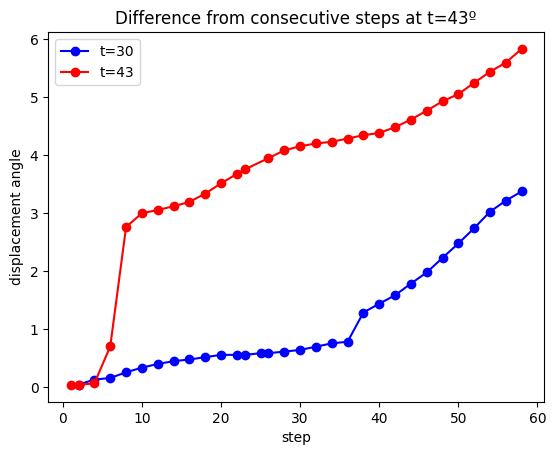

In [27]:
for t in temps:
    df_t = df[t]
    #Create log measure
    df_2 = df_t + 1
    df_log = df_2.apply('log')

    #Normalize and sort columns of normal and log dfs
    L = list(df_t.columns)
    L.sort()
    df_norm = pd.DataFrame([])
    df_norm.index=df_t.index
    df_rel = pd.DataFrame([])
    df_rel.index=df_t.index



    for x in L:
        arr = np.array(df_t[x].tolist())
        normalized_arr = arr / np.sqrt(np.sum(arr**2))
        relative_arr = arr / np.sum(arr)
        df_norm[x] = normalized_arr
        df_rel[x] = relative_arr

    #Compute succesive steps thetas
    #phi
    L = df_t.columns
    L = list(L)
    L.sort()



    cos_phi = []
    for i in range(len(L)-1):
        a = np.array(df_norm[L[i]].tolist()) 
        b = np.array(df_norm[L[i+1]].tolist()) 
        cos_phi.append(np.dot(a,b))
    cos_phi = np.around(cos_phi, decimals=4)
    phi = np.arccos(np.array(cos_phi))

    y_phi = phi
    y_phi_log = phi_log
    x = np.array(L[:-1])


    # Sum of cummulative phi

    y_phi = [phi[0]]

    for i in range(1,len(phi)):
        d_s = x[i]-x[i-1]
        y_phi.append(y_phi[i-1]+(phi[i])*d_s)

    y_phi = np.array(y_phi)

    with open(f'./computes_results/cumphi_{t}', 'w') as f:
        for i in range(len(y_phi)):
            f.write(f'{x[i]}, {y_phi[i]}\n')

    plt.plot(x, y_phi, 'o-', label=f't={t}', c=cmap[t])

plt.ylabel('displacement angle')
plt.xlabel('step')
plt.yscale('linear')
plt.legend(loc='best')
plt.title(f'Difference from consecutive steps at t={t}º')
plt.savefig(f'phi_cum.jpg')